<a href="https://colab.research.google.com/github/nawaz0x1/Poridhi-Machine-Learning/blob/main/CUDA/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with CUDA

## Setup

In [1]:
!wget https://raw.githubusercontent.com/nawaz0x1/Poridhi-Machine-Learning/refs/heads/main/CUDA/beluga.jpg

--2024-12-19 11:44:03--  https://raw.githubusercontent.com/nawaz0x1/Poridhi-Machine-Learning/refs/heads/main/CUDA/beluga.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48330 (47K) [image/jpeg]
Saving to: ‘beluga.jpg’

beluga.jpg          100%[===================>]  47.20K  --.-KB/s    in 0.009s  

2024-12-19 11:44:04 (5.31 MB/s) - ‘beluga.jpg’ saved [48330/48330]



In [2]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

In [3]:
path_img = Path('beluga.jpg')

In [4]:
img = io.read_image(path_img)
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 536, 536])


tensor([[[104, 105, 106, 108],
         [107, 108, 108, 109],
         [112, 112, 112, 112]],

        [[ 58,  59,  60,  62],
         [ 59,  61,  60,  62],
         [ 60,  61,  60,  61]]], dtype=torch.uint8)

In [5]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 150, 22500)

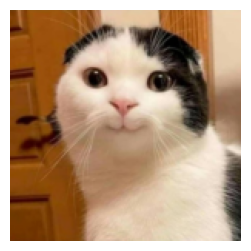

In [7]:
show_img(img2)

## RGB -> Grey

### Basic Python

In [8]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [9]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 966 ms, sys: 8.76 ms, total: 975 ms
Wall time: 991 ms


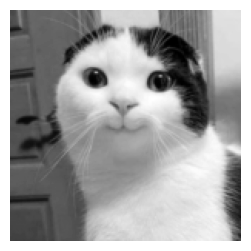

In [10]:
show_img(img_g, cmap='gray')

### Python Kernel

In [11]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

NB: A kernel can not return anything. It can only change contents of things passed to it.

In [12]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [13]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

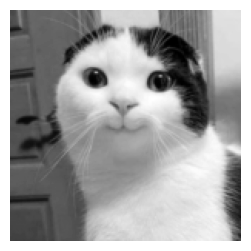

In [14]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

### Python Block Kernel

In [15]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [16]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [17]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

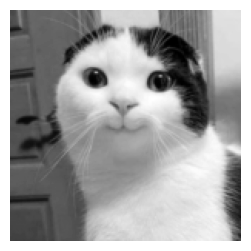

In [18]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

### CUDA Setup

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [20]:
%pip install -q wurlitzer ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 11.1 MB/s eta 0:00:00


In [21]:
%load_ext wurlitzer

In [22]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [23]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

In [24]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [25]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [26]:
!export CUDA_HOME=/usr/local/cuda

In [27]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include

Loading extension module inline_ext...


In [28]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [29]:
imgc = img.contiguous().cuda()

In [30]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 1.08 ms, sys: 9 µs, total: 1.09 ms
Wall time: 1.84 ms


(536, 536, 287296)

h*w: 536*536


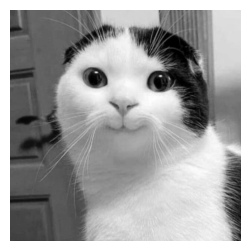

In [31]:
show_img(res, cmap='gray')

## Matmul

### Python matmul

In [70]:
m1 = m2 = torch.tensor([
    [1., 2., 3., 4., 5.],
    [1., 2., 3., 4., 5.],
    [1., 2., 3., 4., 5.],
    [1., 2., 3., 4., 5.],
    [1., 2., 3., 4., 5.],
                        ])
m1.shape,m2.shape

(torch.Size([5, 5]), torch.Size([5, 5]))

In [71]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 5), (5, 5))

In [72]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 5])

In [73]:
for i in range(ar):
    for j in range(bc):
        for k in range(ac):
            t1[i,j] += m1[i,k] * m2[k,j]

In [74]:
t1.shape

torch.Size([5, 5])

In [75]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [76]:
t1

tensor([[15., 30., 45., 60., 75.],
        [15., 30., 45., 60., 75.],
        [15., 30., 45., 60., 75.],
        [15., 30., 45., 60., 75.],
        [15., 30., 45., 60., 75.]])

In [77]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [78]:
%time t1=matmul(m1, m2)

CPU times: user 4.8 ms, sys: 0 ns, total: 4.8 ms
Wall time: 4.66 ms


In [79]:
ar*bc*ac

125

### 2d Python kernel

In [80]:
from types import SimpleNamespace as ns

In [81]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i0,y=i1), ns(x=j0,y=j1), threads, *args)

In [82]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [83]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [84]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

### CUDA matmul

In [49]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [50]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [51]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [85]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [86]:
torch.isclose(res, module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [87]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 456 µs, sys: 50 µs, total: 506 µs
Wall time: 431 µs


torch.Size([5, 5])

### Pytorch

In [88]:
torch.isclose(res, (m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [89]:
%timeit -n 10 _=(m1c@m2c).cpu()

The slowest run took 4.38 times longer than the fastest. This could mean that an intermediate result is being cached.
83.9 µs ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
